In [1]:
import tensorflow_datasets as tfds
import numpy as np


import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
#import matplotlib.pyplot as plt
#ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [2]:
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

In [3]:
encoder = info.features['text'].encoder

print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [4]:
info, info.splits['train'].num_examples

(tfds.core.DatasetInfo(
     name='imdb_reviews',
     version=0.1.0,
     description='Large Movie Review Dataset.
 This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
     urls=['http://ai.stanford.edu/~amaas/data/sentiment/'],
     features=FeaturesDict({
         'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
         'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
     }),
     total_num_examples=100000,
     splits={
         'test': 25000,
         'train': 25000,
         'unsupervised': 50000,
     },
     supervised_keys=('text', 'label'),
     citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
       author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, An

In [5]:
for train_example, train_label in train_data.take(1): #create a dataset of one sample
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [768  99 416   9 733   1 626   6 467 159]
Label: 0


In [6]:
encoder.decode(train_example)

'Just because someone is under the age of 10 does not mean they are stupid. If your child likes this film you\'d better have him/her tested. I am continually amazed at how so many people can be involved in something that turns out so bad. This "film" is a showcase for digital wizardry AND NOTHING ELSE. The writing is horrid. I can\'t remember when I\'ve heard such bad dialogue. The songs are beyond wretched. The acting is sub-par but then the actors were not given much. Who decided to employ Joey Fatone? He cannot sing and he is ugly as sin.<br /><br />The worst thing is the obviousness of it all. It is as if the writers went out of their way to make it all as stupid as possible. Great children\'s movies are wicked, smart and full of wit - films like Shrek and Toy Story in recent years, Willie Wonka and The Witches to mention two of the past. But in the continual dumbing-down of American more are flocking to dreck like Finding Nemo (yes, that\'s right), the recent Charlie & The Chocola

In [7]:

for (x,y) in tfds.as_numpy(train_data.take(2)): #remove take(2)
    print(x.shape, y)

(906,) 0
(855,) 1


In [8]:
#vectorize x
def vectorize_sequences(number_of_examples, dimension, data):
    results = np.zeros((number_of_examples, dimension ))
    labels = np.zeros((number_of_examples))
    for i, (x,y) in enumerate(tfds.as_numpy(data)): 
        results[i, x] = 1.  # set specific indices of results[i] to 1s
        labels[i]=int(y)
    return (results, labels)
#vectorize train data
(x_train, y_train) = vectorize_sequences(info.splits['train'].num_examples, encoder.vocab_size, train_data)
(x_test, y_test) = vectorize_sequences(info.splits['test'].num_examples, encoder.vocab_size, test_data)

print(y_train.shape)
#see the values
for i,i1 in zip(x_train[0:1], x_test[0:1]):
    for j,j1 in zip(i[0:2],i1[0:2]):
        print(j, j1)


(25000,)
0.0 0.0
1.0 1.0


In [9]:
a=np.array([2,1,3,4,0, 10])
a[[2,4,5]]=1
a


array([2, 1, 1, 4, 1, 1])

In [10]:
import pathlib
import os
logdir = pathlib.Path("../tensorboard_logs/overfit_and_underfit")
if not logdir.exists():
    os.makedirs(logdir)
name='default'

In [49]:
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='default'
history= model.fit(x_train, y_train, epochs=20, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 121us/sample - loss: 0.4727 - accuracy: 0.7976 - val_loss: 0.3352 - val_accuracy: 0.8740
Epoch 2/20
25000/25000 [==============================] - 2s 90us/sample - loss: 0.2510 - accuracy: 0.9094 - val_loss: 0.3038 - val_accuracy: 0.8778
Epoch 3/20
25000/25000 [==============================] - 2s 91us/sample - loss: 0.1900 - accuracy: 0.9332 - val_loss: 0.3099 - val_accuracy: 0.8772
Epoch 4/20
25000/25000 [==============================] - 2s 87us/sample - loss: 0.1530 - accuracy: 0.9469 - val_loss: 0.3339 - val_accuracy: 0.8717
Epoch 5/20
25000/25000 [==============================] - 2s 99us/sample - loss: 0.1258 - accuracy: 0.9572 - val_loss: 0.3688 - val_accuracy: 0.8662
Epoch 6/20
25000/25000 [==============================] - 2s 92us/sample - loss: 0.1068 - accuracy: 0.9645 - val_loss: 0.4085 - val_accuracy: 0.8625
Epoch 7/20
25000/25000 [==============================]

In [39]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             multiple                  130976    
_________________________________________________________________
dense_25 (Dense)             multiple                  272       
_________________________________________________________________
dense_26 (Dense)             multiple                  17        
Total params: 131,265
Trainable params: 131,265
Non-trainable params: 0
_________________________________________________________________


In [40]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
5,0.103152,0.96616,0.418004,0.85960,5
6,0.085939,0.97364,0.461000,0.85588,6
7,0.070638,0.98084,0.508267,0.85524,7
8,0.056915,0.98600,0.557475,0.84840,8
9,0.044948,0.99008,0.594817,0.84920,9


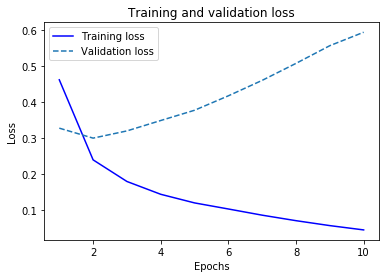

In [41]:

import matplotlib.pyplot as plt

loss = history.history['loss']
acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


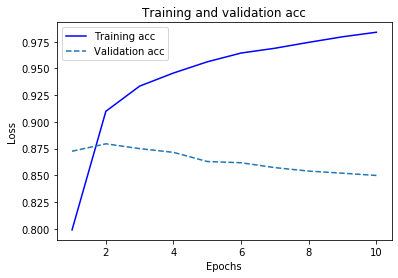

In [20]:

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [21]:
#smaller
model = keras.Sequential([
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='smaller'
smaller_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 93us/sample - loss: 0.6467 - accuracy: 0.6549 - val_loss: 0.5929 - val_accuracy: 0.7582
Epoch 2/10
25000/25000 [==============================] - 2s 75us/sample - loss: 0.4951 - accuracy: 0.8357 - val_loss: 0.4337 - val_accuracy: 0.8630
Epoch 3/10
25000/25000 [==============================] - 2s 78us/sample - loss: 0.3382 - accuracy: 0.9036 - val_loss: 0.3399 - val_accuracy: 0.8777
Epoch 4/10
25000/25000 [==============================] - 2s 70us/sample - loss: 0.2560 - accuracy: 0.9202 - val_loss: 0.3117 - val_accuracy: 0.8786
Epoch 5/10
25000/25000 [==============================] - 2s 70us/sample - loss: 0.2147 - accuracy: 0.9323 - val_loss: 0.3007 - val_accuracy: 0.8806
Epoch 6/10
25000/25000 [==============================] - 2s 73us/sample - loss: 0.1883 - accuracy: 0.9400 - val_loss: 0.3010 - val_accuracy: 0.8803
Epoch 7/10
25000/25000 [==============================] 

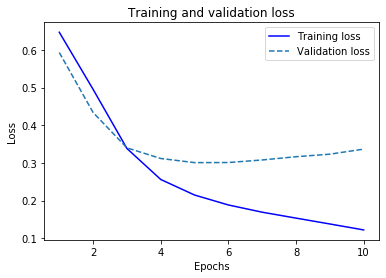

In [22]:

import matplotlib.pyplot as plt

loss = smaller_history.history['loss']
acc = smaller_history.history['accuracy']
val_loss = smaller_history.history['val_loss']
val_acc = smaller_history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

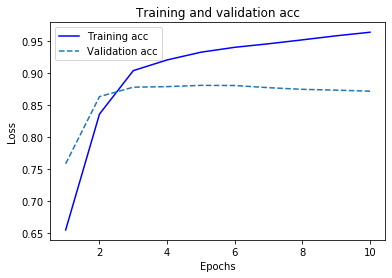

In [23]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
#huge
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='huge'
huge_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 14s 577us/sample - loss: 0.3973 - accuracy: 0.8195 - val_loss: 0.3124 - val_accuracy: 0.8705
Epoch 2/10
25000/25000 [==============================] - 14s 557us/sample - loss: 0.1596 - accuracy: 0.9402 - val_loss: 0.3230 - val_accuracy: 0.8697
Epoch 3/10
25000/25000 [==============================] - 14s 546us/sample - loss: 0.0414 - accuracy: 0.9894 - val_loss: 0.4580 - val_accuracy: 0.8642
Epoch 4/10
25000/25000 [==============================] - 14s 548us/sample - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.5896 - val_accuracy: 0.8639
Epoch 5/10
25000/25000 [==============================] - 13s 536us/sample - loss: 6.9156e-04 - accuracy: 1.0000 - val_loss: 0.6845 - val_accuracy: 0.8648
Epoch 6/10
25000/25000 [==============================] - 14s 558us/sample - loss: 2.1933e-04 - accuracy: 1.0000 - val_loss: 0.7311 - val_accuracy: 0.8661
Epoch 7/10
25000/25000 [============

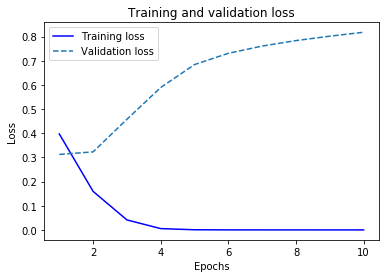

In [32]:

import matplotlib.pyplot as plt

loss = huge_history.history['loss']
acc = huge_history.history['accuracy']
val_loss = huge_history.history['val_loss']
val_acc = huge_history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

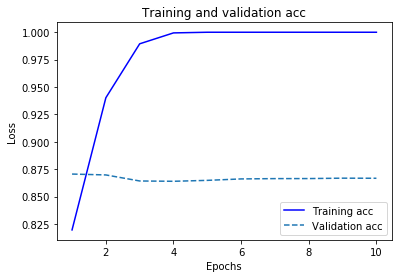

In [33]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [27]:
#regularization
#l2(0.001 ) every coef in weight matrix will add 0.001*weight_coef_value to the total loss of the network
#square of the value of the weight coeffs
#l1 - absolute value of the weight coeffs
model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='regularization'
reg_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 132us/sample - loss: 0.4801 - accuracy: 0.8146 - val_loss: 0.3665 - val_accuracy: 0.8771
Epoch 2/10
25000/25000 [==============================] - 2s 89us/sample - loss: 0.2869 - accuracy: 0.9165 - val_loss: 0.3575 - val_accuracy: 0.8784
Epoch 3/10
25000/25000 [==============================] - 2s 88us/sample - loss: 0.2424 - accuracy: 0.9336 - val_loss: 0.3736 - val_accuracy: 0.8747
Epoch 4/10
25000/25000 [==============================] - 2s 89us/sample - loss: 0.2177 - accuracy: 0.9438 - val_loss: 0.4026 - val_accuracy: 0.8686
Epoch 5/10
25000/25000 [==============================] - 2s 94us/sample - loss: 0.2034 - accuracy: 0.9500 - val_loss: 0.4197 - val_accuracy: 0.8643
Epoch 6/10
25000/25000 [==============================] - 2s 87us/sample - loss: 0.1950 - accuracy: 0.9518 - val_loss: 0.4441 - val_accuracy: 0.8609
Epoch 7/10
25000/25000 [==============================]

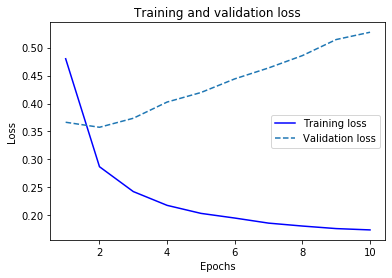

In [34]:
import matplotlib.pyplot as plt

loss = reg_history.history['loss']
acc = reg_history.history['accuracy']
val_loss = reg_history.history['val_loss']
val_acc = reg_history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

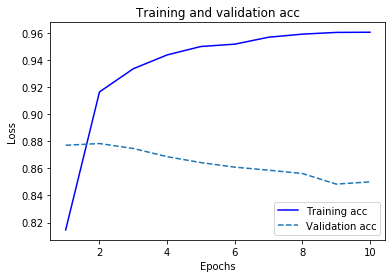

In [35]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [31]:
#dropout

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
name='dropout'
dopout_history= model.fit(x_train, y_train, epochs=10, batch_size=512,
                    validation_data=(x_test, y_test),
                   callbacks=[tf.keras.callbacks.TensorBoard(logdir/name)])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 118us/sample - loss: 0.6426 - accuracy: 0.6131 - val_loss: 0.5166 - val_accuracy: 0.8290
Epoch 2/10
25000/25000 [==============================] - 2s 98us/sample - loss: 0.4884 - accuracy: 0.7805 - val_loss: 0.3697 - val_accuracy: 0.8716
Epoch 3/10
25000/25000 [==============================] - 2s 86us/sample - loss: 0.3792 - accuracy: 0.8505 - val_loss: 0.3138 - val_accuracy: 0.8777
Epoch 4/10
25000/25000 [==============================] - 2s 85us/sample - loss: 0.3145 - accuracy: 0.8838 - val_loss: 0.2930 - val_accuracy: 0.8814
Epoch 5/10
25000/25000 [==============================] - 2s 95us/sample - loss: 0.2696 - accuracy: 0.9080 - val_loss: 0.2896 - val_accuracy: 0.8808
Epoch 6/10
25000/25000 [==============================] - 2s 84us/sample - loss: 0.2419 - accuracy: 0.9167 - val_loss: 0.2958 - val_accuracy: 0.8786
Epoch 7/10
25000/25000 [==============================]

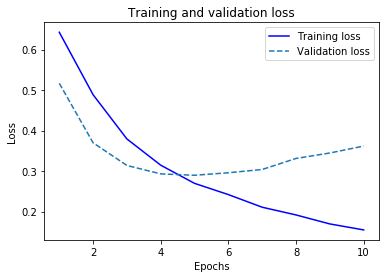

In [43]:
import matplotlib.pyplot as plt

loss = dopout_history.history['loss']
acc = dopout_history.history['accuracy']
val_loss = dopout_history.history['val_loss']
val_acc = dopout_history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, '--', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

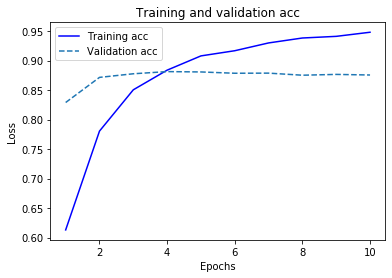

In [44]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

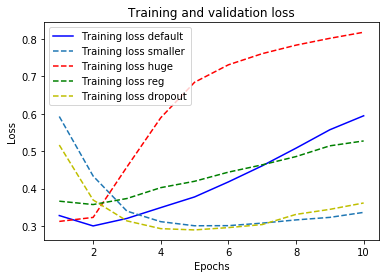

In [48]:
loss_default = history.history['val_loss']
loss_small = smaller_history.history['val_loss']
loss_huge = huge_history.history['val_loss']

loss_reg = reg_history.history['val_loss']
loss_drop = dopout_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_default, 'b', label='Val loss default')
plt.plot(epochs, loss_small, '--', label='Val loss smaller')
plt.plot(epochs, loss_huge, 'r--', label='Val loss huge')
plt.plot(epochs, loss_reg, 'g--', label='Val loss reg')
plt.plot(epochs, loss_drop, 'y--', label='Val loss dropout')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()